# Laboratorio 7 (Aprendizaje por refuerzo) Grupo 1
 <h3>Valores iniciales optimistas<h3>
 <HR>
 <h3>
  NOMBRES:
  
  * POLO ORELLANA BRAYAN SIMON
  * LOPEZ CHIRI DIMAR GABRIEL
  
  <br>
  CARRERA: INGENIERIA DE SISTEMAS
  <BR>
  FECHA: 17/06/2024 <BR>

  * [Enlace de invitacion para ser colaborador](https://github.com/bspoloo/SIS420-012024/invitations)
  
  * [Enlace al git hub](https://github.com/bspoloo/SIS420-012024/tree/main/Laboratorios/Laboratorio%207)

 <h3>

# Valores iniciales
El método de valores iniciales optimistas es una técnica utilizada en el aprendizaje por refuerzo para incentivar la exploración por parte del agente. En lugar de inicializar todos los valores Q a cero o algún otro valor neutro, los valores Q se inicializan a valores elevados. Esto hace que el agente sea más propenso a explorar acciones que no ha tomado antes, ya que inicialmente cree que todas las acciones tienen una alta recompensa esperada.

En Q-learning, cada acción en cada estado tiene un valor Q asociado que representa la recompensa esperada de tomar esa acción en ese estado y seguir la política óptima a partir de ahí. Si estos valores Q se inicializan a un valor alto (optimista), el agente tenderá a explorar más porque:

Exploración Inicial: Al inicio, el agente no tiene suficiente información sobre el entorno. Los valores iniciales optimistas hacen que todas las acciones parezcan atractivas.
Descuento de Acciones Menos Óptimas: A medida que el agente explora y obtiene recompensas reales, las acciones que no son óptimas recibirán actualizaciones negativas en sus valores Q, mientras que las acciones óptimas mantendrán o aumentarán sus valores.
Reducción Gradual de Exploración: Con el tiempo, el agente aprenderá los valores reales de las acciones y el incentivo para explorar disminuirá, permitiendo que el agente se concentre en las mejores acciones basadas en la experiencia acumulada.

In [51]:
#Importamos la librería gym para poder utilizar el entorno de OpenAI
import gymnasium as gym
#Importamos la librería numpy para poder trabajar con arrays
import numpy as np
#Importamos la librería matplotlib para poder realizar gráficas
import matplotlib.pyplot as plt 
#Importamos la librería os para poder interactuar con el sistema operativo
import os
#Importamos la función clear_output de la librería IPython.display para poder limpiar la salida de la celda
from IPython.display import clear_output
#Importamos la librería random para poder generar números aleatorios 
import random
#Importamos la librería matplotlib para poder realizar gráficas 
import matplotlib.pyplot as plt
#Importamos la librería pickle para poder guardar los datos en un archivo 
import pickle
#Importamos la librería time para poder utilizar la función sleep
import time
#Importamos la librería pandas para poder trabajar con dataframes 
import pandas as pd

## Creacion de funcion para graficar las recompensas acumuladas cada episodio
Esta Clase tien la funcion de graficar, el cual toma los parametros de premios por episodio, el numero de episodios:

In [52]:
class RewardGraphic():
    def __init__(self, window_size= 1):
        self.window_size = window_size

    def Graphic_reward_per_episode(self, rewards_per_episode, episodes, epsilons):
        plt.figure(figsize=(10, 6))  # Tamaño de la figura
        
        for i, epsilon in enumerate(epsilons):
            sum_rewards = np.zeros(episodes)
            for t in range(episodes):
                sum_rewards[t] = np.sum(rewards_per_episode[epsilon][max(0, t-self.window_size):(t+1)])

            print(f"Final average reward for epsilon={epsilon}:", np.mean(sum_rewards[-1000:]))
            plt.plot(sum_rewards, label=f'$\epsilon$ = {epsilon}')

        plt.xlabel('Episodes')
        plt.ylabel('Suma de recompensas')
        plt.title('Suma de recompensas a lo largo del tiempo')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'CliffWalking_combined.png')
        plt.show()
        
    def Graphic_reward_per_epsilon(self, reward_per_epsilon, epsilons):
        plt.figure(figsize=(8, 5))
        for i, epsilon in enumerate(epsilons):
            plt.plot(reward_per_epsilon[epsilon], label=f'$\epsilon$ = {epsilon}')
        plt.legend()
        plt.grid(True)
        plt.xlabel('Episodios')
        plt.ylabel('Recompensa media')
        plt.title('Recompensa media por episodio para diferentes valores de $\epsilon$')
        plt.show()

<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_29940\3537484811.py:14: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(sum_rewards, label=f'$\epsilon$ = {epsilon}')
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_29940\3537484811.py:27: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(reward_per_epsilon[i], label=f'$\epsilon$ = {epsilon}')
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_29940\3537484811.py:32: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Recompensa media por episodio para diferentes valores de $\epsilon$')


## Implementacion del Modelo
Para este modelo se crearon dos clases, el `Game` y `Agente`, esto para tener el codigo mas entendible y mas ordenado:

### Game
La clase `Game` contiene sus atributos y metodos, donde nos ayudaran a interactuar con el agente y su entorno para la **exploracion**, **explotacion**, importacion y explotacion del ``agente``:

**Parametros:**
- Agente: esta es la clase principal el cual contiene el entorno, este entorno es el que contiene espacio de estados y un espacio de acciones para que un agente interactúe con él
- Explore: este parametro nos sirve para verifcar que el entorno actual es de exploracion o explotacion, ``False`` y ``True``

**Metodos:**
- is_explore(): esta funcion valida que el agente este en modo exploracion o explotacion:
    * Exploracion: Si el agente esta en modo exploracion inicia la tabla `q` y `actions` del agente en vacio
    * Explotacion: Si el agente esta en modo explotacion caragara el archivo `.pkl` donde esta almacenada una tabla de una exploracion anteriro
- optimistic_initial_values(): este metodo verifica que el agente esta en modo exploracion y que el epsilon sea 0, si es asi este inicial los valores de q del agente en alto.
- run(): este es el metodo mas importante de la clase `Game`, ya que toma el numero de episodios y ejecuta cada episodo, esta es la parte donde el agente en verdad aprende.

In [53]:
class Game():
    def __init__(self, Agent, explore=True):
        self.agent = Agent
        self.explore = explore
        self.is_explore()
        self.optimistic_initial_values()

    def is_explore(self):
        if self.explore:
            self.agent.q = np.zeros((self.agent.env.observation_space.n, self.agent.env.action_space.n))
        else:
            self.agent.load_pickle()

    def optimistic_initial_values(self):
        print("Setting optimistic initial values")
        if self.explore:
            self.agent.q = np.full((self.agent.env.observation_space.n, self.agent.env.action_space.n), self.agent.optimistic_value)

    def run(self, episodes=100):
        # parametro para renderizar el entorno cada episodio
        RENDER_AT_EPISODE = 1
        rewards_per_episode = np.zeros(episodes)
        
        # Empezamos la exploracion del agente
        for episode in range(episodes):
            state = self.agent.reset()
            episode_reward = 0  # primero inicializamos el estado en 0
            terminated = False
            truncated = False
            done = False
            
            #mientra el agente haya terminado o se haya truncado, este seguira tomando acciones, depende de la politica
            while not terminated and not truncated:
                
                #se toma la accion que el agente elige, con la funcion propia de el.
                action = self.agent.choose_action(state, self.explore)
                # retornamos el nuevo estado, la recompensa, si se termino o se truncó el episodio, esto de acuerdo a la accion ingresada
                next_state, reward, terminated, truncated, _ = self.agent.env.step(action)
                
                done = terminated or truncated
                
                #Verificamos que el agente este en modo exploracion, si es asi, se aprende
                if self.explore:
                    self.agent.learn(state, action, reward, next_state, done)
                
                #Actualizamos el estado
                state = next_state
                #suma la recompensa que el agente obtiene
                episode_reward += reward
            
            if episode % RENDER_AT_EPISODE == 0:
                clear_output(wait=True)
                self.agent.env.render()
                
            #guardamos la recompensa por episodio en una array
            rewards_per_episode[episode] = episode_reward
            print(f"Episode {episode}/{episodes}, Epsilon: {self.agent.epsilon:.4f}, Reward: {episode_reward:.4f}")
        #Guardamos el modelo en un archivo
        self.agent.save_pickle()
        #Retornamos las recompensas por episodio
        self.agent.env.close()
        return rewards_per_episode

### Agente
Esta clase tiene es nuestro agente, el que interactua con el entorno del juego, el que toma las acciones:

- Hyperparametros:
    * epsilon:  $\epsilon$ es un parámetro crucial en las políticas de aprendizaje por refuerzo, permitiendo al agente equilibrar la exploración y la explotación para aprender de manera eficiente en un entorno dinámico.
    * alpha: $\alpha$ (alpha) es el parámetro de tasa de aprendizaje (learning rate). Este parámetro controla cuánto se actualizan los valores en la tabla Q o la función de valor en cada paso de aprendizaje.
    * gamma: En el contexto del aprendizaje por refuerzo (Reinforcement Learning, RL), $\gamma$ (gamma) es el parámetro del factor de descuento (discount factor). Este parámetro determina la importancia de las recompensas futuras en la toma de decisiones del agente.

- Variables del Agente:
    * url_pickle: Ruta para guardar o cargar la tabla Q en un archivo pickle.
    * episode_reward: Recompensa acumulada por episodio.
    * env: El entorno en el que opera el agente.
    * q: La tabla Q que almacena los valores de Q para cada estado-acción.
    * action_counts: Cuenta de cuántas veces se ha tomado cada acción en cada estado.

- Explicación Adicional
    * reset: Restablece el entorno y devuelve el estado inicial.
    * select_best_action: Selecciona la mejor acción posible en un estado dado basado en los valores Q actuales.
    * choose_action: Elige una acción basada en la política $\epsilon$-greedy.
    * learn: Actualiza los valores de la tabla Q utilizando la fórmula de Q-learning.
    * save_pickle: Guarda la tabla Q en un archivo.
    * load_pickle: Carga la tabla Q desde un archivo.

In [54]:
class Agent():
    def __init__(self,env ,epsilon, alpha=0.01, gamma=0.99, optimistic_value = 10.0):
        #hiperparametros, aqui se añade un nuevo hiperparametro llamado optimistic_value
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.optimistic_value = optimistic_value
        #variables
        self.url_pickle = f"CliffWalking{self.epsilon}.pkl"
        self.episode_reward = 0
        self.env = env
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        self.action_counts = np.zeros((env.observation_space.n, env.action_space.n))
    
    def reset(self):
        return self.env.reset()[0]
    
    def select_best_action(self, explore, state):
        max_q = np.max(self.q[state, :])
        actions = np.where(self.q[state, :] == max_q)[0]
        return np.random.choice(actions)

    def choose_action(self, state, explore):
        if explore and np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return self.select_best_action(explore, state)

    def learn(self, state, action, reward, next_state, done):
        best_next_action = np.argmax(self.q[next_state])
        td_target = reward + self.gamma * self.q[next_state, best_next_action] * (not done)
        self.q[state, action] += self.alpha * (td_target - self.q[state, action])
        self.action_counts[state, action] += 1

    def save_pickle(self):
            with open(self.url_pickle, "wb") as f:
                pickle.dump(self.q, f)

    def load_pickle(self):
        print("Loading pickle")
        with open(self.url_pickle, 'rb') as f:
            self.q = pickle.load(f)
            self.action_counts = np.zeros(self.env.action_space.n)

## Exploracion del agente
La exploracion del agente consiste en probar diferentes acciones para descubrir cuáles resultan en las mejores recompensas a largo plazo. Es un componente crucial en la estrategia de aprendizaje porque permite al agente evitar quedarse atrapado en una solución subóptima que puede parecer buena en el corto plazo pero no lo es a largo plazo.

En esta parte haremos que diferentes agentes con diferentes valores de epsilon, exploren el entorno del `CliffWalking`, y almacenaremos las recompensas por episodio para luego mostrarlas en una grafica para ver el comportamiento de del agente a lo largo de los episodio.

In [55]:
#los valores de epsilon que se van a probar
#Intentaremos con 0 para ver el comportamiento del agente valores iniciales optimistas
epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
reward_per_epsilon = {}
reward_per_episode = {}

#Creamos un diccionario para guardar los diferentes games
games = {}


#variable para renderizar el entorno
render = False

#Creamos el entorno
env = gym.make('CliffWalking-v0', render_mode="human" if render else None)

#Interamos por cada epsilon, un nuevo agente y lo guardamos en el diccionario de games
for epsilon in epsilons:
    agent = Agent(env ,epsilon)
    game = Game(agent, explore=True)
    games[epsilon] = game

# Para cada epsilon, corremos el juego y guardamos la recompensa por episodio, y obtenemos la recompensa promedio por epsilon
for epsilon, game in games.items():
    #cada juego se corre 1000 veces
    episodes = 200
    reward_per_episode[epsilon] = game.run(episodes)
    reward_per_epsilon[epsilon] =  reward_per_episode[epsilon]/ episodes

Episode 199/200, Epsilon: 1.0000, Reward: -251269.0000


Final average reward for epsilon=0: -7773.765
Final average reward for epsilon=0.1: -12214.555
Final average reward for epsilon=0.2: -18233.865
Final average reward for epsilon=0.3: -24023.33
Final average reward for epsilon=0.4: -22909.33
Final average reward for epsilon=0.5: -25618.025
Final average reward for epsilon=0.6: -30725.205
Final average reward for epsilon=0.7: -41559.475
Final average reward for epsilon=0.8: -62673.64
Final average reward for epsilon=0.9: -142693.115
Final average reward for epsilon=1.0: -630484.465


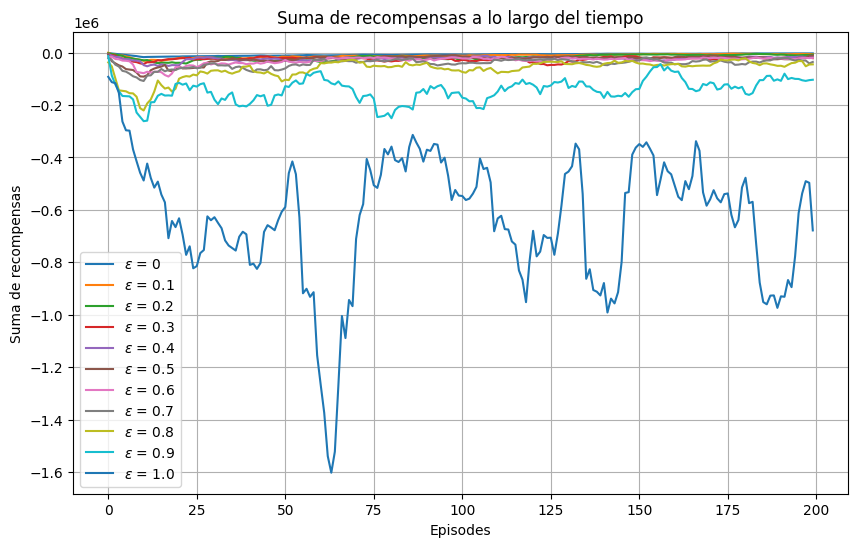

In [56]:
graphic = RewardGraphic()
graphic.Graphic_reward_per_episode(reward_per_episode, episodes, epsilons)

KeyError: 2

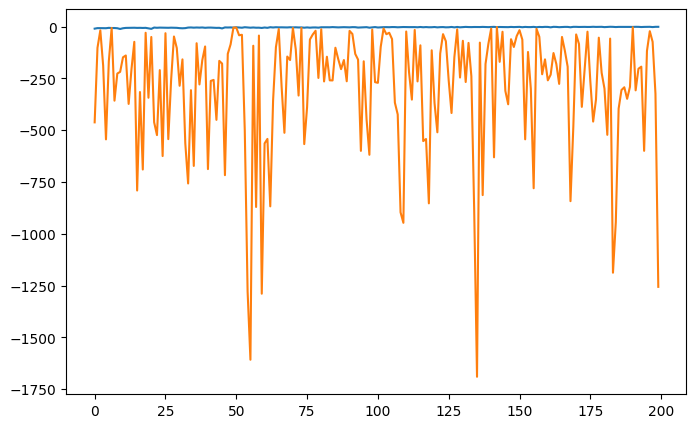

In [59]:
graphic.Graphic_reward_per_epsilon(reward_per_epsilon, epsilons)

In [21]:
render = True
explore = False
epsilon = 1
env = gym.make('CliffWalking-v0', render_mode="human" if render else None)
agent = Agent(env, epsilon)
game = Game(agent, explore=explore)
game.run(2)

Loading pickle
Setting optimistic initial values


KeyboardInterrupt: 

0: Move up

1: Move right

2: Move down

3: Move left

In [1]:
q_df = pd.DataFrame(games[1].agent.q)
print("Q-table as DataFrame:")
q_df

NameError: name 'pd' is not defined